对数据进行处理是训练一个良好模型的前提。

详见 [Pytorch官方数据集与数据加载器](https://docs.pytorch.ac.cn/tutorials/beginner/basics/data_tutorial.html)

## 💡 意义一：工程化与效率（为训练提速）

### 1. 批量处理 (Batching)
* **问题：** 现代深度学习训练采用**随机梯度下降 (SGD)** 及其变种（如 Adam）。这些优化算法不是对单个样本求梯度，而是对一批（Batch）样本的平均梯度进行更新。
* **`DataLoader` 的意义：** `DataLoader` 负责将数百万个样本组织成一个个预定大小的 **Batch**。这使得 GPU 或 CPU 能够进行高效的**并行计算**，充分利用硬件资源，大大加快训练速度。

### 2. 内存管理与加载优化
* **问题：** 许多数据集（尤其是图像和视频）非常庞大，无法一次性全部加载到内存或 GPU 显存中。
* **`Dataset` & `DataLoader` 的意义：**
    * **`Dataset`** 负责定义如何获取**单个**样本及其标签。
    * **`DataLoader`** 则采用 **按需加载（On-demand Loading）** 机制。它只在需要时（即当前 Batch 迭代时）才从磁盘读取数据，并通过设置 `num_workers` 参数启用 **多进程 (Multiprocessing)** 来提前并行加载下一个 Batch 的数据，这被称为 **“预取 (Prefetching)”**，有效缓解了训练过程中的 **“数据瓶颈”**。

### 3. 数据混洗 (Shuffling)
* **意义：** 在每个 Epoch 开始前，`DataLoader` 通常会对数据顺序进行随机打乱 (Shuffling)。这对于 SGD 至关重要，因为它能确保模型在训练过程中不会被数据中的特定顺序模式所误导，提高模型的泛化能力。

---

## 💡 意义二：数据抽象与灵活性（定制化数据流）

### 4. 抽象化和解耦 (Decoupling)
* **`Dataset` 的意义：** 它将 **“数据读取和预处理”** 的逻辑与 **“模型训练”** 的逻辑彻底分离。
    * 无论是从文件系统读取图像、从 CSV 文件读取文本，还是从数据库获取数据，这些底层细节都被封装在 `Dataset` 的 `__getitem__` 方法中。
    * 这样，当您更换数据集时，只需要修改 `Dataset` 的实现，而核心的训练循环代码（模型定义、优化器、训练步骤）几乎不需要变动，提高了代码的**可维护性**和**可复用性**。

### 5. 数据转换与增强 (Transforms)
* **意义：** `Dataset` 是进行数据预处理和数据增强（如图像的随机裁剪、翻转、标准化等）的理想场所。
    * 这些操作可以直接应用于每个样本，确保所有进入模型的 Batch 都经过了正确的转换。
    * 数据增强是提高模型**泛化能力**、防止**过拟合**的关键手段之一。

### 6. 自动整理 (Collate)
* **`DataLoader` 的意义：** 即使所有样本都是从 `Dataset` 获取的，它们也可能需要进一步整理才能堆叠成一个张量 (Tensor Batch)。
    * **`collate_fn`** 参数允许您自定义如何将单个样本（例如不同长度的文本序列或嵌套结构）整理成一个统一的 Batch 张量，满足 PyTorch 模型的输入要求。

---

## 总结：`Dataset` & `DataLoader` 的核心价值

| 组件 | 核心职能 | 对训练的意义 |
| :--- | :--- | :--- |
| **`Dataset`** | **数据抽象与单样本处理** | 封装数据来源和预处理逻辑，实现代码解耦和数据增强。 |
| **`DataLoader`** | **高效数据流与批量处理** | 实现批量加载、数据混洗、多进程预取，保证 GPU/CPU 的高效利用。 |

简单来说，**`Dataset` 解决了“如何处理单个数据”的问题，而 `DataLoader` 解决了“如何高效、稳定地将批次数据喂给模型”的问题。** 它们是连接原始数据和高性能训练流程的桥梁。

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%
100.0%
100.0%
100.0%


In [5]:
print(training_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [19]:
import random
sample_idx = random.randint(0, len(training_data))
print(sample_idx)

26389


In [ ]:
# this is the same
sample_idx = torch.randint(len(training_data), size=(1,)).item()

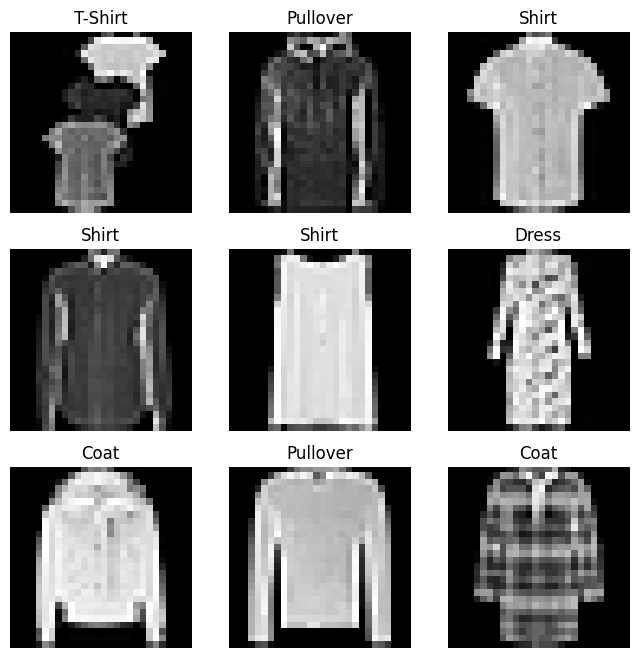

In [20]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = random.randint(0, len(training_data))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


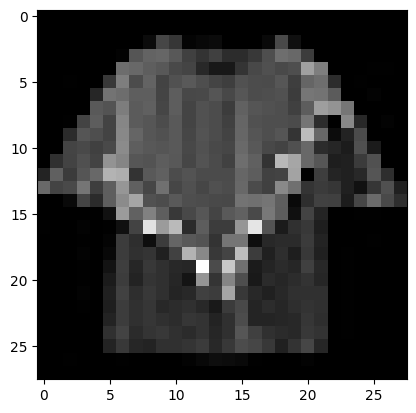

Label: 6


In [24]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")